In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import openpathsampling.engines.toy as toys
import numpy as np
from openpathsampling import SShootingSimulation
from openpathsampling import SShootingAnalysis
from openpathsampling.engines.toy import DoubleWell
from openpathsampling.engines.toy import OverdampedLangevinIntegrator

# S-shooting

This example demonstrates how an S-shooting simulation is carried out and analyzed in OPS. The theoretical background for S-shooting is provided in the following publication:

Menzl, G., Singraber, A. & Dellago, C. S-shooting: a Bennett–Chandler-like method for the computation of rate constants from committor trajectories. Faraday Discuss. __195__, 345–364 (2017), https://doi.org/10.1039/C6FD00124F

Here, we reproduce with OPS the example of a Brownian walker in a double-well potential given in the above publication. Please refer to the paper for a detailed description of nomenclature and simulation setup.

__Note__: For satisfactory results with good statistics a high number of initial snapshots should be used (~1000+). Unfortunately, with the current performance this will then NOT be a _quick_ example. In order to keep the execution time within a few minutes the number of snapshots was set to a low number (see `n_snapshots` parameter below) but the results will probably not be matching with the reference publication.

## Trajectory sampling

First, we set up our simple test system, a single particle in a 2-dimensional potential energy surface consisting of two gaussian wells and outer walls. The particle is propagated with an overdamped Langevin integrator.

In [2]:
# Set simulation details.
D              = 1.0     # Diffusion constant.
beta           = 4.0     # Beta.

dt             = 0.001   # Timestep delta t [time units]
tau            = 0.5     # One-way trajectory length tau [time units] (= maximum correlation function time).
n_corr_points  = 501     # Number of correlation function points (t = 0 counts also).

A_max          = -0.4    # Upper boundary for region A.
S_min          = -0.1    # Lower boundary for region S.
S_max          = 0.1     # Upper boundary for region S.
B_min          = 0.4     # Lower boundary for region B.

n_snapshots    = 100     # Number of shooting points (= initial snapshots).
n_per_snapshot = 1       # Number of trajectories generated per shooting point.

temperature = 1 / beta
L = int(tau / dt)
n_steps_per_frame = int(L / (n_corr_points - 1))
trajectory_length = n_corr_points - 1

# Sanity checks
if L * dt != tau:
    raise ValueError("Total simulation length is not a multiple of time step length:\n"
                     "L * dt = {0:d} * {1:f} = {2:f} != {3:f} = tau.".format(L, dt, L * dt, tau))
if n_steps_per_frame * (n_corr_points - 1) != L:
    raise ValueError("Trajectory length is not a multiple of steps per frame and"
                     " number of requested correlation function points:\n"
                     "n_steps_per_frame * (n_corr_points - 1) = {0:d} * {1:d} = {2:d} != "
                     "{3:d} = L.".format(n_steps_per_frame, (n_corr_points - 1),
                                         n_steps_per_frame * (n_corr_points - 1), L))
    
print("Temperature       = ", temperature)
print("L                 = ", L)
print("n_steps_per_frame = ", n_steps_per_frame)
print("trajectory_length = ", trajectory_length)

Temperature       =  0.25
L                 =  500
n_steps_per_frame =  1
trajectory_length =  500


In [3]:
pes = DoubleWell([1.0], [1.0])

topology = toys.Topology(
    n_atoms = 1,
    n_spatial = 1,
    masses = [1.0],
    pes = pes
)

# D = kB * T / gamma      
#gamma = temperature / D                
#integ = toys.LangevinBAOABIntegrator(dt, temperature, gamma)
integ = OverdampedLangevinIntegrator(dt, temperature, D)
options = {
    'integ' : integ,
    'n_frames_max' : 5000,
    'n_steps_per_frame' : n_steps_per_frame
}

toy_eng = toys.Engine(
    options = options,
    topology = topology
)
toy_eng.initialized = True
paths.PathMover.engine = toy_eng

Next the initial snapshots are randomly chosen within the region $S$ according to their Boltzmann weight $e^{-\beta E(x_0)}$ (rejection sampling). Usually these configurations are available from a preceding simulation, e.g. umbrella sampling. For a biased sampling select $k \neq 0$ below.

In [4]:
def Epot(x):
    toy_eng.positions = np.array([x])
    return pes.V(toy_eng)

x0 = 0.0
k = 50
#k = 0
def Ebias(x):
    return 0.5 * k * (x - x0)**2

In [5]:
# Choose initial point.
#x = np.random.uniform(S_min, S_max)
x =  0.0
points = [np.array([[x]])]

# Set displacement and number of MC steps for each new snapshot position.
mcdisp = 0.1
mcsteps = 100

# Initialize some counters.
mcacc = 0
mcrej = 0
mcmov = 0
E_S = 0.0

# Loop to create snapshots positions.
for i in range(n_snapshots - 1):
    x = points[-1][0][0]
    # Perform MC steps.
    for m in range(mcsteps):
        xnew = x + mcdisp * np.random.normal()
        Eold = Epot(x) + Ebias(x)
        Enew = Epot(xnew) + Ebias(xnew)
        # Stay always in S.
        if S_min < xnew and xnew < S_max:
            # Metropolis MC scheme.
            if Eold > Enew:
                x = xnew
                E = Enew
                mcacc += 1
            else:
                if np.random.uniform() < np.exp(-beta * (Enew - Eold)):
                    x = xnew
                    E = Enew
                    mcacc += 1
                else:
                    E = Eold
                    mcrej += 1
        else:
            E = Eold
            mcrej += 1
        # Add new energy to average.    
        E_S += E            
        mcmov += 1
    # Append new position to list.
    points.append(np.array([[x]]))

# Create snapshot template and list of initial snapshots.
template = toys.Snapshot(
    coordinates = np.array([[0.0]]),
    velocities = np.array([[0.0]]),
    engine = toy_eng
)
snapshots = [template.copy_with_replacement(coordinates=point) for point in points]

print("-----------------------------------------------------")
print("Generated", n_snapshots, "initial snapshot positions.")
print( "-----------------------------------------------------")
print( "Average energy   : ", E_S / (n_snapshots * mcsteps))
print( "Acceptance ratio : ", float(mcacc) / mcmov)
print( "-----------------------------------------------------")

-----------------------------------------------------
Generated 100 initial snapshot positions.
-----------------------------------------------------
Average energy   :  1.0496176591142172
Acceptance ratio :  0.5388888888888889
-----------------------------------------------------


Let's plot the potential energy and the corresponding weight in the $S$ region:

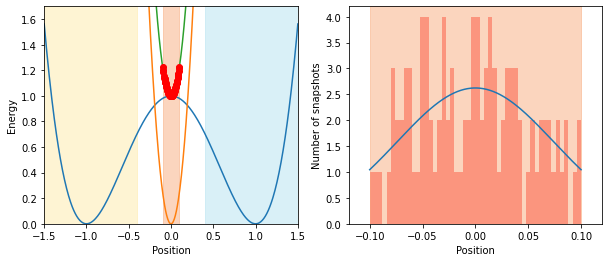

In [6]:
# Plot settings.
delta = 0.01
x_min = -1.5
x_max = 1.5
n_histo = 50
fig = plt.figure(figsize=plt.figaspect(0.4))

# First plot.
ax = fig.add_subplot(1, 2, 1)
ax.set_xlim(x_min, x_max)
ax.set_xlabel("Position")
ax.set_ylim(0.0, 1.7)
ax.set_ylabel("Energy")
# Epot and Ebias functions.
X = np.linspace(x_min, x_max, num=500)
Y_Epot = np.array([Epot(x) for x in X])
Y_Ebias = np.array([Ebias(x) for x in X])
ax.plot(X, Y_Epot)
ax.plot(X, Y_Ebias)
ax.plot(X, Y_Epot + Y_Ebias)
# Initial snapshot positions.
X_sn = np.array([s.xyz[0][0] for s in snapshots])
Y_sn = np.array([Epot(x) + Ebias(x) for x in X_sn])
ax.plot(X_sn, Y_sn, "ro")
# Region background colors.
ax.axvspan(x_min, A_max, alpha=0.5, color='#FEEBA9')
ax.axvspan(S_min, S_max, alpha=0.5, color='#F9AC7E')
ax.axvspan(B_min, x_max, alpha=0.5, color='#B4E2F1')

# Second plot.
ax = fig.add_subplot(1, 2, 2)
w = S_max - S_min
ax.set_xlim(S_min - 0.1 * w, S_max + 0.1 * w)
ax.set_xlabel("Position")
ax.set_ylabel("Number of snapshots")
# Calculate and plot expected histogram distribution.
X = np.linspace(S_min, S_max, num=500)
Y = np.array([np.exp(-beta * (Epot(x) + Ebias(x))) for x in X])
Y_factor = n_snapshots * w / n_histo / np.trapz(Y, X)
Y_distr = np.array([Y_factor * np.exp(-beta * (Epot(x) + Ebias(x))) for x in X])
ax.plot(X, Y_distr)
# Add histogram of initial snapshot positions.
X_sn = np.array([s.xyz[0][0] for s in snapshots])
ax.hist(X_sn, np.linspace(S_min, S_max, num=n_histo+1), facecolor="r", alpha=0.5)
ax.axvspan(S_min, S_max, alpha=0.5, color='#F9AC7E')

Furthermore we need a method to define states $A$, $S$ and $B$, we use the $x$-coordinate:

In [7]:
def pos1D(snapshot):
    return snapshot.xyz[0][0]

cv_x = paths.CoordinateFunctionCV(name="cv_x", f=pos1D)

state_A = paths.CVDefinedVolume(cv_x, -10000, A_max)
state_S = paths.CVDefinedVolume(cv_x, S_min, S_max)
state_B = paths.CVDefinedVolume(cv_x, B_min, 10000)

Finally, we need a randomizer and a storage object:

In [8]:
randomizer = paths.NoModification()

In [9]:
storage = paths.Storage("sshooting-1d.nc", mode="w", template=template)

Now all ingredients are combined to form the S-shooting simulation:

In [10]:
simulation = SShootingSimulation(
    storage = storage,
    engine = toy_eng,
    state_S = state_S,
    randomizer = randomizer,
    initial_snapshots = snapshots,
    trajectory_length = trajectory_length
)

Upon calling the `run` method the trajectories are harvested and saved.

In [11]:
%%time
simulation.run(n_per_snapshot=n_per_snapshot)

Working on snapshot 100 / 100; shot 1 / 1
CPU times: user 3min 59s, sys: 1.03 s, total: 4min
Wall time: 4min


Let's plot some of the obtained trajectories:

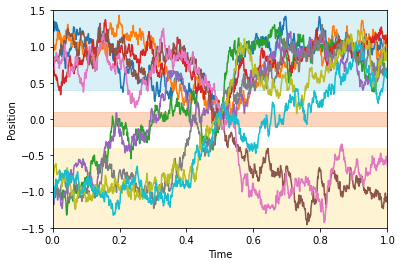

In [12]:
# Plot settings.
y_min = -1.5
y_max = 1.5
max_traj = 10
fig, ax = plt.subplots()

# Set axis limits.
ax.set_xlim(0, 2 * tau)
ax.set_xlabel("Time")
ax.set_ylim(y_min, y_max)
ax.set_ylabel("Position")
# Loop over all trajectories and print "max_traj" (or less) of them.
for traj in storage.steps[0::max([1, int(len(storage.steps) / float(max_traj))])]:
    # Calculate frame times.
    X = [n_steps_per_frame * dt * i for i in range(0, len(traj.change.trials[-1]))]
    # Get coordinates from trajectories.
    Y = []
    for snapshot in traj.change.trials[-1]:
        for point in snapshot.coordinates:
            Y.append(float(point))
    # Plot trajectories.
    ax.plot(X, Y, "-")
# Region background colors.
ax.axhspan(y_min, A_max, alpha=0.5, color='#FEEBA9')
ax.axhspan(S_min, S_max, alpha=0.5, color='#F9AC7E')
ax.axhspan(B_min, y_max, alpha=0.5, color='#B4E2F1')        

In [13]:
storage.close()

## S-shooting analysis

Given the data from the S-shooting simulation we can now analyze the harvested trajectories. First, open the data file with the previously generated trajectories:

In [14]:
storage = paths.Storage("sshooting-1d.nc", "r")

Define bias function, required as argument for S-shooting analysis:

In [15]:
def b(snapshot):
    Ebias = 0.5 * k * (cv_x(snapshot) - x0)**2
    return np.exp(-beta * Ebias)

cv_b = paths.CoordinateFunctionCV(name="cv_b", f=b)

Now start the S-shooting analysis, this may take a while. If a bias was selected above ($k \neq 0$), add the bias CV as function argument.

In [16]:
%%time
results = SShootingAnalysis(steps=storage.steps,
                            states=[state_A, state_B, state_S],
                            bias=cv_b)


CPU times: user 5min 53s, sys: 260 ms, total: 5min 53s
Wall time: 5min 53s


The `calculate_averages` function returns a number of important results, such as these numbers globally averaged over all snapshots and trials:

`M` ... Total number of harvested trajectory segments: $M$

`Ns` ... Average number of trajectory points in $S$: $\left<N_S[x(\tau)]\right>_B$

`I_Bt` ... Average of inverse bias sum over all trajectories: $\left<\frac{1}{\tilde{B}[x(\tau)]}\right>_B$

`Ns_Bt` ... Average of $N_S$ divided by bias sum over all trajectories: $\left<\frac{N_S[x(\tau)]}{\tilde{B}[x(\tau)]}\right>_B$

`hAhB_Bt` ... Array with average of $h_A(0)h_B(t)$ divided by bias sum over all trajectories: $\left<\frac{h_A(0)h_B(t)}{\tilde{B}[x(\tau)]}\right>_B$

In addition the same quantities are available for each snapshot individually via the returned dictionary (`results_per_snap`):

In [17]:
M, Ns, I_Bt, Ns_Bt, hAhB_Bt, results_per_snap = results.calculate_averages()
print("M     = ", M)
print("Ns    = ", Ns)
print("I_Bt  = ", I_Bt)
print("Ns_Bt = ", Ns_Bt)

M     =  50100
Ns    =  43.8349500998004
I_Bt  =  0.05953756540293415
Ns_Bt =  1.3298719678447435


The per-snapshot results may be accessed like this:

In [18]:
snap = list(results_per_snap.keys())[0]
snap_result = results_per_snap[snap]
print("M     = ", snap_result["M"])
print("Ns    = ", snap_result["Ns"])
print("I_Bt  = ", snap_result["I_Bt"])
print("Ns_Bt = ", snap_result["Ns_Bt"])

M     =  501
Ns    =  10.870259481037925
I_Bt  =  0.1277706224627812
Ns_Bt =  1.3622840344867455


The `hAhB_Bt` array allows us to plot the time correlation function $\left<h_A(0)h_B(t)\right>_S$ in the $S$-ensemble and its derivative. We also included reference data from Brownian dynamcis from the reference paper.

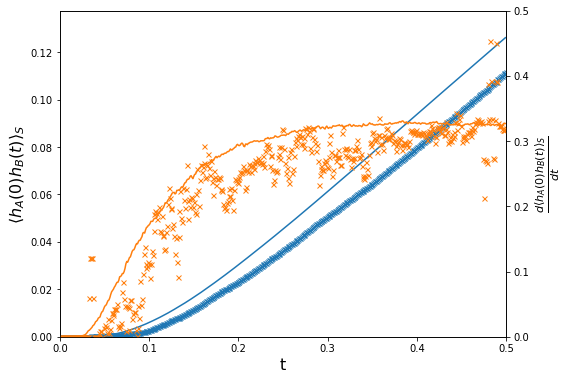

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

# Prepare and plot reference data.
ref_data = np.loadtxt("reference-sshooting.data")
ref_gradient = np.gradient(ref_data.T[1], ref_data.T[0][1]-ref_data.T[0][0])
ax.set_xlim([0.0, 0.5])
ax.set_ylim([0.0, 0.1375])
ax.set_xlabel(r't', fontsize=16)
ax.set_ylabel(r'$\left<h_A(0)h_B(t)\right>_S$', fontsize=16)
ax.plot(ref_data.T[0], ref_data.T[1], "C0-")
ax2 = ax.twinx()
ax2.set_xlim([0.0, 0.5])
ax2.set_ylim([0.0, 0.5])
ax2.set_ylabel(r'$\frac{d \left<h_A(0)h_B(t)\right>_S}{d t}$', fontsize=16)
ax2.plot(ref_data.T[0], ref_gradient, "C1-")

# Prepare and plot S-shooting data.
delta = n_steps_per_frame * dt
X = np.array([delta * i for i in range(trajectory_length + 1)])
Y = np.gradient(hAhB_Bt/I_Bt, delta)
ax.plot(X, hAhB_Bt/I_Bt, "C0x", ms=5)
ax2.plot(X, Y, "C1x", ms=5)

The average number of points in the $S$-region in the $S$-ensemble $\left<N_S[x(\tau)]\right>_S$ can be easily computed:

In [20]:
Ns_Bt / I_Bt

22.336687078897658

Finally, if the averages $\left<h_A\right>$ and $\left<h_S\right>$ are provided (see the reference paper) we can plot the derivative of the time correlation function and thus estimate the rate $k_{AB}$ as the plateau value ($k_{AB} = 0.056$).

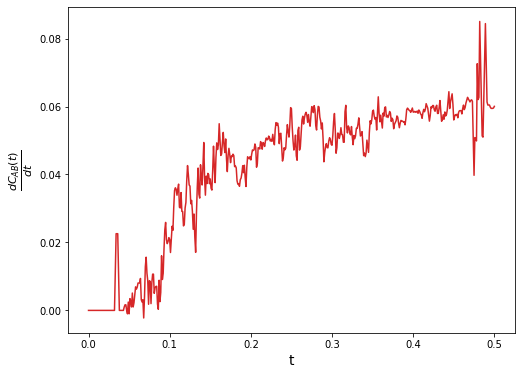

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

X = np.array([delta * i for i in range(trajectory_length + 1)])
C_AB = results.C_AB(hA=0.487, hS=0.00407)
dC_ABdt = np.gradient(C_AB, delta)
ax.set_xlabel(r't', fontsize=14)
ax.set_ylabel(r'$\frac{d C_{AB}(t)}{d t}$', fontsize=16)
ax.plot(X, dC_ABdt, 'C3-')